In [1]:
import os
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# read all data in foler
file_list = []
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        file_list.append(os.path.join(dirname, filename))

dfs = []
for file in file_list:
    df = pd.read_csv(file)
    #print(f"File: {file}, Columns: {df.columns}, DataTypes: {df.dtypes}")
    if 'Symbol' in df.columns:
        if (df.shape[0] == 5306) & (df['Symbol'].nunique() == 1):
            dfs.append(df)

df = pd.concat(dfs, axis=0).sort_values(['Date','Symbol']).drop(['Trades','Deliverable Volume','%Deliverble'], axis=1)



**The reason why we need to create features is that the original dataset has limited features, so we need to perform feature engineering.**

In [3]:
# create features
def create_feature(df):
    df['Open_t+1'] = df['Open'].shift(-1)
    df['Close_t+1'] = df['Close'].shift(-1)
    df['factor_overnight_OHLCV_t0'] = df['Open_t+1']/df['Close'] - 1
    df['factor_HL_OHLCV'] = df['High']/df['Low'] - 1
    df['factor_HO_OHLCV'] = df['High']/df['Open'] - 1
    df['factor_LO_OHLCV'] = df['Low']/df['Open'] - 1
    df['factor_CH_OHLCV'] = df['Close']/df['High'] - 1
    df['factor_CL_OHLCV'] = df['Close']/df['Low'] - 1
    df['daily'] = df['Close_t+1']/df['Open_t+1'] - 1
    #df['factor_turnover_OHLCV'] = df['Volume']/df['Trades']
    df['factor_amihud_highLow_OHLCV'] = (df['factor_HL_OHLCV'] * 1000000)/df['Volume']
    df['Close_t-1'] = df['Close'].shift(1)
    df['factor_daily_OHLCV'] = df['Close']/df['Close_t-1'] - 1
    df['factor_amihud_OHLCV'] = (df['factor_daily_OHLCV'] * 1000000).abs()/df['Volume']
    #df['factor_size_OHLCV'] = df['Trades'] * df['Close']
create_feature(df)
df = df.sort_values(['Date','Symbol']).dropna()
df['Date'] = pd.to_datetime(df['Date'])
# check length of each stock
df = df[(df['Date'] >= '2000-01-04') & (df['Date'] <= '2021-04-29')]
df.groupby('Symbol')['Date'].count()

Symbol
ASIANPAINT    5304
BPCL          5304
CIPLA         5304
DRREDDY       5304
GRASIM        5304
HDFC          5304
HDFCBANK      5304
ICICIBANK     5304
IOC           5304
ITC           5304
M&M           5304
ONGC          5304
RELIANCE      5304
SBIN          5304
SUNPHARMA     5304
TITAN         5304
WIPRO         5304
Name: Date, dtype: int64

<a id='part2'></a>
## Time Series Generator  
In this step, it is quite crucial because our data structure is panel data. If we build a time series model in the usual way, it will combine different stocks into one window. So, we need to create generators for each individual stock and then merge these generators into one large batch. The train-test split should also be done based on stocks.

You might wonder why not initially create separate generators for each stock, make predictions, and then select stocks afterward. This is because I want to build a shared model, which means the model can learn from other stocks' variations during training. The advantage of this approach is that it can capture industry-related patterns, increase the amount of data available, and reduce the risk of overfitting.

In [4]:
# split data
def split_data(df, date, features, target):
    train = df[df['Date'] < date]
    test = df[df['Date'] >= date]
    X_train, y_train = np.array(train[features]), train[target].values
    X_test, y_test = np.array(test[features]), test[target].values
    return X_train, y_train, X_test, y_test

# check shape
def check_shape(data):
    print(data.shape)

In [5]:
# create time series
length = 60
batch_size = 64
train_generators = []
test_generators = []
stock_list = df['Symbol'].unique().tolist()
features = [i for i in df.columns if 'factor_' in i]

scalers = {}
for stock in stock_list:
    stock_data = df[df['Symbol'] == stock]
    X_train, y_train, X_test, y_test = split_data(stock_data, '2019-01-01', features, 'daily')
    scaler = MinMaxScaler((-1,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    scalers[stock] = scaler
    train_gen = TimeseriesGenerator(X_train, y_train, length=length, batch_size=batch_size)
    test_gen = TimeseriesGenerator(X_test, y_test, length=length, batch_size=batch_size)
    train_generators.append(train_gen)
    test_generators.append(test_gen)

In [6]:
# check batches
X_train_batches = []
y_train_batches = [] # len(X_train_batches) : 17、64、60、9

for gen in train_generators:
    X_train_batch, y_train_batch = next(iter(gen))
    X_train_batches.append(X_train_batch)
    y_train_batches.append(y_train_batch)

X_train_combines = np.concatenate(X_train_batches, axis=0) 
y_train_combines = np.concatenate(y_train_batches, axis=0)
print(f"X_combine shape:{X_train_combines.shape}") 
print(f"y_combine shape:{y_train_combines.shape}") 

X_combine shape:(1088, 60, 9)
y_combine shape:(1088,)


In [7]:
X_test_batches = []
y_test_batches = []

for gen in test_generators:
    X_test_batch, y_test_batch = next(iter(gen))
    X_test_batches.append(X_test_batch)
    y_test_batches.append(y_test_batch)

X_test_combines = np.concatenate(X_test_batches, axis=0)
y_test_combines = np.concatenate(y_test_batches, axis=0)

In [8]:
# build LSTM model
model = Sequential()
model.add(LSTM(50, activation='tanh',return_sequences=True, input_shape=(length, len(features))))
model.add(Dropout(0.1))
model.add(LSTM(25, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit the model
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model.fit(X_train_combines, y_train_combines, validation_data=(X_test_combines, y_test_combines), epochs=200, callbacks=[es, reduce_lr], verbose=0)

<AxesSubplot:>

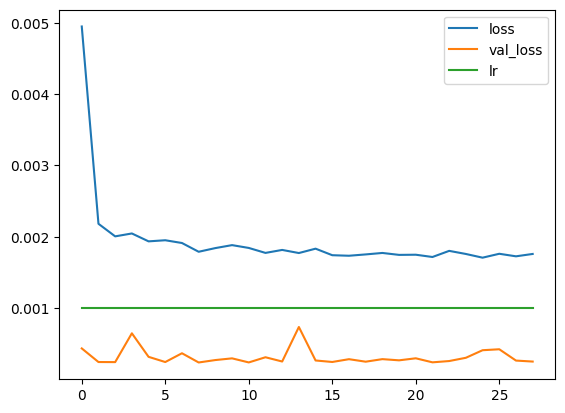

In [9]:
pd.DataFrame(model.history.history).plot()

In [10]:
# test prediction
test_pred = []
for stock_idx, gen in enumerate(test_generators):
    X_train_stock = train_generators[stock_idx].data
    current_batch = X_train_stock[-length:].reshape(1,length,len(features))
    
    stock_pred = []
    for i in range(len(gen.data)):
        current_pred = model.predict(current_batch, verbose=0)[0][0]
        stock_pred.append(current_pred)
        
        next_row = gen.data[i].reshape(1, 1, len(features))
        current_batch = np.append(current_batch[:, 1:, :], next_row, axis=1)
#     # inverse data with scaler if need
#     stock = stock_list[stock_idx]
#     stock_pred = scalers[stock].inverse_transform(np.array(stock_pred).reshape(-1,1)).flatten()
    test_pred.append(stock_pred)
test_pred = np.array(test_pred)

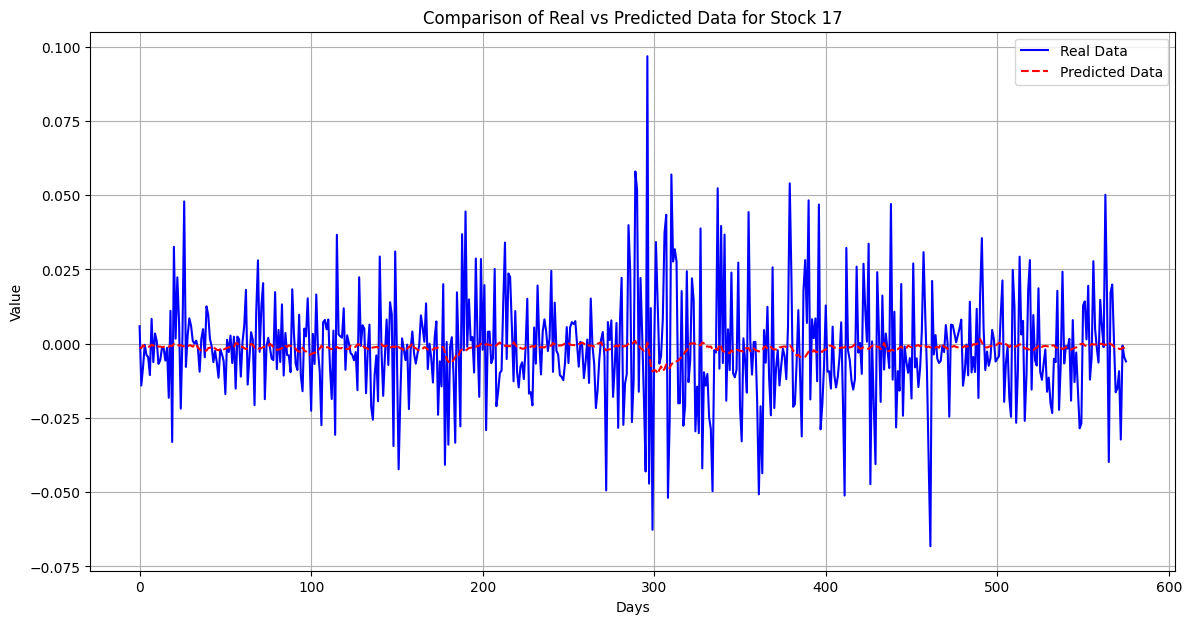

In [11]:
# plot the result of stock_idx = 0
real_data = test_generators[1].targets
predicted_data = np.array(test_pred)[1]

plt.figure(figsize=(14, 7))
plt.plot(real_data, label="Real Data", color="blue")
plt.plot(predicted_data, label="Predicted Data", color="red", linestyle="--")
plt.title(f"Comparison of Real vs Predicted Data for Stock {stock_idx + 1}")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# If you need to fill some missing value...
# for i, arr in enumerate(test_pred):
#     arr_np = np.array(arr)
#     if arr_np.shape[0] != 577:
#         padding = np.zeros((577 - arr_np.shape[0], arr_np.shape[1]))
#         test_pred[i] = np.concatenate([arr_np, padding], axis=0)
# test_pred_array = np.squeeze(np.stack(test_pred, axis=0))

In [13]:
# build strategy --> choose the most hightest daily reutrn stock and change day by day
# prepare real data
actual_returns = []
for stock in stock_list:
    stock_data = df[(df['Symbol'] == stock) & (df['Date'] >= '2019-01-01')]
    actual_returns.append(stock_data['daily'].values)
actual_returns = np.array(actual_returns)

# choose the highest daily return stock
stock_choose = np.argmax(test_pred, axis=0) # (576, 1)
stock_choose_return = actual_returns[stock_choose, np.arange(actual_returns.shape[1])]

In [14]:
ret = pd.DataFrame(stock_choose_return, columns=['Return'])
ret['Return_fee'] = ret['Return'] - (2*0.001425*0.28) - 0.003
ret['Return_cumsum'] = ret['Return_fee'].cumsum()
ret['Return_cumprod'] = (1 + ret['Return_fee']).cumprod() - 1
ret['Return_cumprod_dd'] = [(ret['Return_fee'] + 1)[i]/(ret['Return_cumprod'] + 1)[0:i].max() - 1 for i in range(len(ret))]

In [15]:
ret

,Return,Return_fee,Return_cumsum,Return_cumprod,Return_cumprod_dd
0,0.003644,-0.000154,-0.000154,-0.000154,NaN
1,-0.000364,-0.004162,-0.004316,-0.004315,-0.004009
2,-0.033163,-0.036961,-0.041277,-0.041117,-0.036813
3,0.009800,0.006002,-0.035275,-0.035362,0.006157
4,-0.007807,-0.011605,-0.046880,-0.046556,-0.011453
...,...,...,...,...,...
571,-0.000866,-0.004664,-3.104115,-0.961076,-0.004511
572,0.009297,0.005499,-3.098616,-0.960862,0.005653
573,0.025077,0.021279,-3.077337,-0.960029,0.021436
574,-0.000275,-0.004073,-3.081410,-0.960192,-0.003920


<AxesSubplot:>

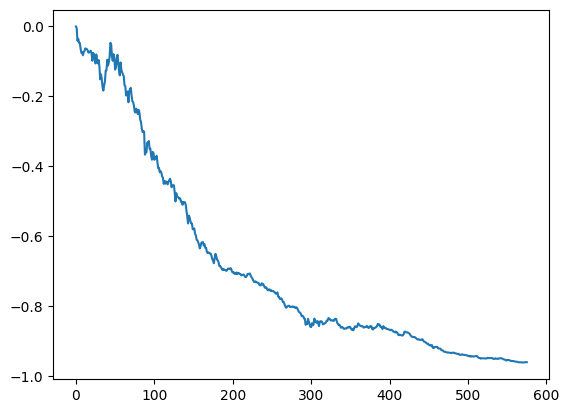

In [16]:
ret['Return_cumprod'].plot()

In [17]:
single_period_return = ret['Return_cumsum'].iloc[-1]
compound_return = ret['Return_cumprod'].iloc[-1]
max_drawdown = ret['Return_cumprod_dd'].min()

print(single_period_return)
print(compound_return)
print(max_drawdown)

-3.084639956821432
-0.9603207480883471
-0.10518864498643743


In [ ]:
# with XGBoost LTR
dtrain = xgb.DMatrix(test_pred.T.reshape(-1,1), label=actual_returns.T.flatten())
group = [17] * 576
dtrain.set_group(group)

param = {
    'objective':'rank:pairwise',
    'eta':0.1,
    'gamma':0.7,
    'min_child_weight':.1,
    'max_depth':8,
        }
bst = xgb.train(param, dtrain, num_boost_round=4)
xgb_pred = bst.predict(dtrain)
xgb_pred_ranked = xgb_pred.reshape(576,17)

In [ ]:
stock_choose_xgb = np.argmax(xgb_pred_ranked, axis=1)
stock_choose_xgb_return = actual_returns[stock_choose_xgb, np.arange(actual_returns.shape[1])]

In [ ]:
ret_xgb = pd.DataFrame(stock_choose_xgb_return, columns=['Return'])
ret_xgb['Return_fee'] = ret_xgb['Return'] - (2*0.001425*0.28) - 0.003
ret_xgb['Return_cumsum'] = ret_xgb['Return_fee'].cumsum()
ret_xgb['Return_cumprod'] = (1 + ret_xgb['Return_fee']).cumprod() - 1
ret_xgb['Return_cumprod_dd'] = [(ret_xgb['Return_fee'] + 1)[i]/(ret_xgb['Return_cumprod'] + 1)[0:i].max() - 1 for i in range(len(ret_xgb))]

In [ ]:
ret_xgb

In [ ]:
ret_xgb['Return_cumsum'].plot()

In [ ]:
# calculate metrics
single_period_return = ret_xgb['Return_cumsum'].iloc[-1]
compound_return = ret_xgb['Return_cumprod'].iloc[-1]
max_drawdown = ret_xgb['Return_cumprod_dd'].min()

print(single_period_return)
print(compound_return)
print(max_drawdown)

**Next, we can perform hyperparameter tuning, similar to grid search, based on the desired metric, in this case, cumulative returns.**

In [ ]:
# do some parameter
def xgb_objective(params):
    bst = xgb.train(param, dtrain, num_boost_round=4)
    xgb_pred = bst.predict(dtrain)
    xgb_pred_ranked = xgb_pred.reshape(576,17)
    stock_choose_xgb = np.argmax(xgb_pred_ranked, axis=1)
    stock_choose_xgb_return = actual_returns[stock_choose_xgb, np.arange(actual_returns.shape[1])]
    ret_xgb = pd.DataFrame(stock_choose_xgb_return, columns=['Return'])
    ret_xgb['Return_fee'] = ret_xgb['Return'] - (2*0.001425*0.28) - 0.003
    ret_xgb['Return_cumsum'] = ret_xgb['Return_fee'].cumsum()
    ret_xgb['Return_cumprod'] = (1 + ret_xgb['Return_fee']).cumprod() - 1
    ret_xgb['Return_cumprod_dd'] = [(ret_xgb['Return_fee'] + 1)[i]/(ret_xgb['Return_cumprod'] + 1)[0:i].max() - 1 for i in range(len(ret_xgb))]
    return ret_xgb['Return_cumsum'].iloc[-1]

param_grid = {
    'objective': ['rank:pairwise'],
    'eta': [0.01, 0.05, 0.1, 0.3],
    'gamma': [0, 0.5, 1, 1.5],
    'min_child_weight': [0.1, 1, 5, 10],
    'max_depth': [3, 4, 5, 6, 7],
}

In [ ]:
best_score = float('-inf')  
best_params = None

for params in ParameterSampler(param_grid, n_iter=100):
    score = xgb_objective(params)
    if score > best_score:  
        best_score = score
        best_params = params
print(best_params)
print(best_score)

Finally, you might wonder if XGBoost is effective when we have only one type of LSTM-predicted returns as a variable. Therefore, we can also input the original features that were used for LSTM into XGBoost. It's important to note that when merging the data, we must ensure that future features are not included in today's prediction results.

In [ ]:
combined_features_list = []

# with last day of train_generators
current_features = np.array([gen.data[-1] for gen in train_generators]) # (17, 9)
lstm_pred = test_pred[:,0] # (17,) --> (17, 1)
combined_features_stock = np.hstack([current_features, lstm_pred[:, np.newaxis]]) # (17, 10)
combined_features_list.append(combined_features_stock)

# combine with test_generator data
for i in range(len(test_generators[0].data) - 1):
    current_features = np.array([gen.data[i] for gen in test_generators])
    lstm_pred = test_pred[:,i+1]
    combined_features_stock = np.hstack([current_features, lstm_pred[:, np.newaxis]])
    combined_features_list.append(combined_features_stock)
    
combined_test_features = np.array(combined_features_list)

In [ ]:
X = combined_test_features.reshape(-1,combined_test_features.shape[-1])  # transform shape to (17*576, num_features+1)
y = actual_returns.flatten() # shape: (9792,)
dtrain = xgb.DMatrix(X, label=y)
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
bst = xgb.train(param, dtrain, num_boost_round=100)

# predict
xgb_pred = bst.predict(dtrain)
xgb_pred_ranked = xgb_pred.reshape(576,17)
stock_choose_xgb = np.argmax(xgb_pred_ranked, axis=1)
stock_choose_xgb_return = actual_returns[stock_choose_xgb, np.arange(actual_returns.shape[1])]

# calculate
ret_xgb_multi = pd.DataFrame(stock_choose_xgb_return, columns=['Return'])
ret_xgb_multi['Return_fee'] = ret_xgb_multi['Return'] - (2*0.001425*0.28) - 0.003
ret_xgb_multi['Return_cumsum'] = ret_xgb_multi['Return_fee'].cumsum()
ret_xgb_multi['Return_cumprod'] = (1 + ret_xgb_multi['Return_fee']).cumprod() - 1
ret_xgb_multi['Return_cumprod_dd'] = [(ret_xgb_multi['Return_fee'] + 1)[i]/(ret_xgb_multi['Return_cumprod'] + 1)[0:i].max() - 1 for i in range(len(ret_xgb_multi))]

The results are as shown in the figure below. In fact, the overall performance has returned to its original state. Therefore, even with the addition of more variables, to some extent, it may have affected XGBoost's learning

In [ ]:
ret_xgb_multi['Return_cumsum'].plot()

In [ ]:
single_period_return = ret_xgb_multi['Return_cumsum'].iloc[-1]
compound_return = ret_xgb_multi['Return_cumprod'].iloc[-1]
max_drawdown = ret_xgb_multi['Return_cumprod_dd'].min()

print(single_period_return)
print(compound_return)
print(max_drawdown)